# REINFORCEMENT LEARNING

### Author: Hyungjoo Kim

##### All data was provided by University College London, Department of Computer Science, Reinforcement Learning Module

##### Supervisor: Prof. Hado Van Hasselt, Matteo Hessel, and Diana Borsa

# Setup
### Import Useful Libraries

In [3]:
import functools
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [9]:
#@title helper functions (run, but don't modify this cell)

def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Part 3: Off-policy multi-step learning 

### Q4 
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [10]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 4.1
Implement the return functions below and run the cells below that.

In [11]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T, ))
  # Compute the importance sampling
  rho_t = pi / mu

  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
        G[t] = r[t] + d[t] * v[t+1]
    else:
        G[t] = r[t] + d[t] * ((1 - l) * v[t+1] + l * G[t+1])
  
  # Multiply the importance sampling correction at each corresponding step t (trajectory)
  for t in reversed(range(T)):
    G[t] *= np.prod(pi[t:]) / np.prod(mu[t:])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l) * v + l * G

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T, ))
  # Compute the importance sampling
  rho_t = pi / mu

  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
#         G[t] = rho_t[t] * r[t]
        G[t] = rho_t[t] * (r[t] + d[t] * v[t+1])
    else:
#         G[t] = rho_t[t] * (r[t] + d[t] * G[t+1])
        G[t] = rho_t[t] * (r[t] + d[t] * ((1 - l) * v[t+1] + l * G[t+1]))
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l) * v + l * G

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T, ))
  # Compute the importance sampling
  rho_t = pi / mu
  # The idea of control variates can be extended to multi-step returns from Lecture 11 note page 28
  delta = r + d * v[1:] - v[:-1]
  delta_rl = np.zeros((T, ))
    
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
        delta_rl[t] = rho_t[t] * delta[t] 
    else:
        delta_rl[t] = rho_t[t] * (delta[t] + d[t] * l * delta_rl[t+1]) 
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return l * delta_rl + v
  
def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T, ))
  # Compute the importance sampling
  rho_t = pi / mu
  # Compute the adaptive bootstrapping with an additional trace parameter
  lambda_t = l * np.minimum(1, 1/rho_t) 
  # The idea of control variates can be extended to multi-step returns from Lecture 11 note page 28
  delta = r + d * v[1:] - v[:-1]
  delta_rl = np.zeros((T, ))

  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.    
    if t == T - 1:
        delta_rl[t] = lambda_t[t] * rho_t[t] * delta[t] 
    else:
        delta_rl[t] = lambda_t[t] * rho_t[t] * (delta[t] + d[t] * l * delta_rl[t+1]) 
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return l * delta_rl + v

In [14]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int64)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state
  # in this case, observations are just the real states
  observations = states
  # generate rewards
  rewards = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
  # compute discounts
  discounts = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0
  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward

[ 22.761 783.829 233.854   7.514   0.757]


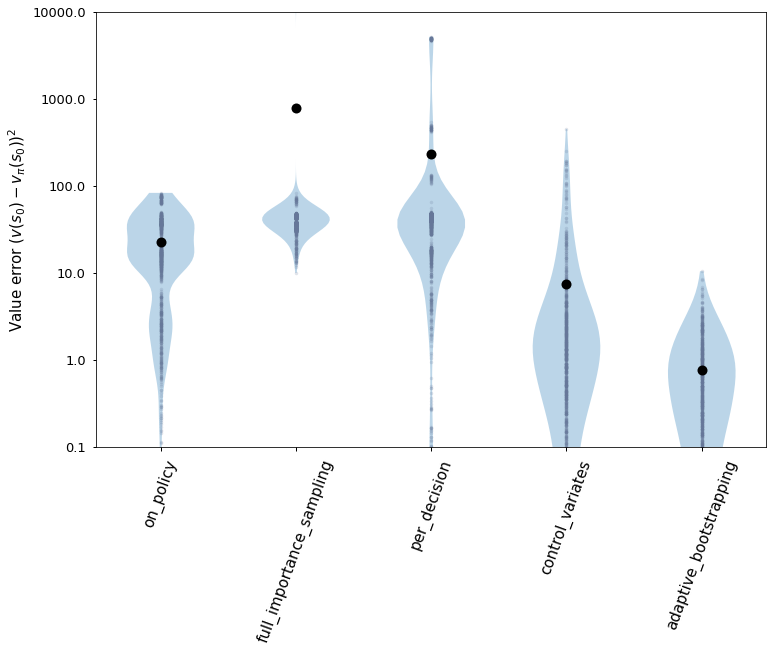

In [15]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision',
        'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 4.2
Explain the ranking in terms of value error of the different return estimates.

> **Best ranking** (worst $\rightarrow$ best)
>
> Full importance sampling < per-decision < on policy < control variates < adaptive bootstraping 
>
> - The big black dot means the distributions of the average error. The full importance sampling looks the highest error compared to the others (on-policy, per-decision, control variates, and adaptive bootstrapping). This is because it can be possible high variance if it applies to the off-policy instead of the on-policy case. In other words, using the importance sampling correction usually has a big issue that the variance would typically be larger and the main purpose of the remaining off-policy methods is to reduce and mitigate variance. Therefore, we can say that the full-importance sampling method performs the worst-case scenario in this question.
>
> - The mean squared value error of the per-decision algorithm looks higher than on-policy, control variates, and adaptive bootstrapping algorithm, but lower than the full importance sampling. This is because early rewards would not depend on the subsequent actions through the per-decision algorithm, so the variance can be reduced.
>
> - The on-policy algorithm generally occurs lower variance than the off-policy method. As above mentioned from the full importance sampling, the importance sampling method often occur larger variance,  but the on-policy method has not used the importance sampling, which is a standard off-policy strategy. Therefore, the mean squared value error of the on-policy method is lower than the full-importance sampling and the per-decision, but still larger than the others as proved in the above figure. 
>
> - The control variates algorithm computes the return with the pre-decision importance sampling with correction and control variates methods. From here, $\delta^{\rho \lambda}_{t}$ is used that it would have lower variance than using $G^{\rho \lambda}_{t} - v(S_t)$ directly. This method sometimes called error weighting, so it performs lower variance than others except for the adaptive bootstrapping method. 
>
> - The adaptive bootstrapping algorithm has the lowest and the best result than the others. This is because it used the same method of the control variates with adding the initial bootstrap parameter, which is $\lambda_t$. This is computed on each step separately and when we are too off-policy, then it helps to truncate the sum of errors.
>
> Therefore, the ranking results can be proved based on the above explanation and the figure.

### Q 4.3 
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> Yes. The bootstrapping when we use the off-policy method is an extremely common trick, especially for policy gradients, which really do not like biased return estimates. This is because if we have biased return estimates, then we no longer necessarily follow the policy gradient that might be harmful. In other words, the policy is no longer necessarily improving. Therefore, the adaptive bootstrapping method could not be always chosen when learning the off-policy method even though it is the best algorithm to solve the problem of too off-policy due to bootstrapping (biased return estimates), so we need to consider ways to mitigate between the variance and the bias. 